In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from zipfile import ZipFile
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [69]:
epsilons = [0, .02, 0.04, 0.06, 0.08, 0.1, 0.12, .2, .25, .3]
pretrained_model = "/content/lenet_mnist_model.pth"
use_cuda=True
# Set random seed for reproducibility
torch.manual_seed(42)

In [70]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [71]:
# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ])),
        batch_size=1, shuffle=True)

In [72]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")

# Initialize the network
model = Net().to(device)

CUDA Available:  False


In [73]:
model.load_state_dict(torch.load(pretrained_model, map_location=device))
model.eval()  # Set the model to evaluation mode

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [74]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    """
    Perform Fast Gradient Sign Method (FGSM) attack on an image.

    Args:
        image (torch.Tensor): The original image.
        epsilon (float): The attack perturbation magnitude.
        data_grad (torch.Tensor): The gradient of the loss with respect to the image.

    Returns:
        torch.Tensor: The perturbed image.
    """
    # Get the sign of the gradients
    sign_data_grad = data_grad.sign()
    # Apply perturbation to the image
    perturbed_image = image + epsilon * sign_data_grad
    # Clip the values to maintain [0, 1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image


# restores the tensors to their original scale
def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Restore the original scale of a batch of normalized tensors.

    Args:
        batch (torch.Tensor): A batch of normalized tensors.
        mean (list or torch.Tensor): The mean used for normalization.
        std (list or torch.Tensor): The standard deviation used for normalization.

    Returns:
        torch.Tensor: The batch of tensors in their original scale.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean, device=batch.device)
    if isinstance(std, list):
        std = torch.tensor(std, device=batch.device)

    # Reshape mean and std to match the dimensions of the batch
    mean = mean.view(1, -1, 1, 1)
    std = std.view(1, -1, 1, 1)

    # Denormalize the batch
    denormalized_batch = batch * std + mean
    return denormalized_batch

In [75]:
def test(model, device, test_loader, epsilon):
    """
    Test the model under an FGSM attack with a given epsilon.

    Args:
        model (torch.nn.Module): The neural network model to test.
        device (torch.device): The device to run the test on (CPU or GPU).
        test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
        epsilon (float): The attack perturbation magnitude.

    Returns:
        float: The test accuracy under the FGSM attack.
        list: A list of adversarial examples.
    """
    # Initialize accuracy counter and adversarial examples list
    correct = 0
    adv_examples = []

    # Iterate over all examples in the test set
    for data, target in test_loader:
        # Move the data and target to the device
        data, target = data.to(device), target.to(device)

        # Enable gradient calculation for the data
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]  # Get the index of the max log-probability

        # Skip the attack if the initial prediction is incorrect
        if init_pred.item() != target.item():
            continue

        # Compute the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Perform backward pass to calculate gradients
        loss.backward()

        # Collect the gradients of the data
        data_grad = data.grad.data

        # Denormalize the data to its original scale
        data_denorm = denorm(data)

        # Apply FGSM attack
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)

        # Re-normalize the perturbed data
        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        # Re-classify the perturbed data
        output = model(perturbed_data_normalized)

        # Determine the new prediction
        final_pred = output.max(1, keepdim=True)[1]  # Get the index of the max log-probability

        # Check if the attack was successful
        if final_pred.item() == target.item():
            correct += 1
            # Save some examples if epsilon is 0
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
        else:
            # Save some adversarial examples for visualization
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))

    # Calculate final accuracy for this epsilon
    final_acc = correct / float(len(test_loader.dataset))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader.dataset)} = {final_acc}")

    # Return the accuracy and adversarial examples
    return final_acc, adv_examples


In [76]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9912 / 10000 = 0.9912
Epsilon: 0.02	Test Accuracy = 9821 / 10000 = 0.9821
Epsilon: 0.04	Test Accuracy = 9693 / 10000 = 0.9693
Epsilon: 0.06	Test Accuracy = 9493 / 10000 = 0.9493
Epsilon: 0.08	Test Accuracy = 9177 / 10000 = 0.9177
Epsilon: 0.1	Test Accuracy = 8743 / 10000 = 0.8743
Epsilon: 0.12	Test Accuracy = 8194 / 10000 = 0.8194
Epsilon: 0.2	Test Accuracy = 4876 / 10000 = 0.4876
Epsilon: 0.25	Test Accuracy = 2714 / 10000 = 0.2714
Epsilon: 0.3	Test Accuracy = 1418 / 10000 = 0.1418


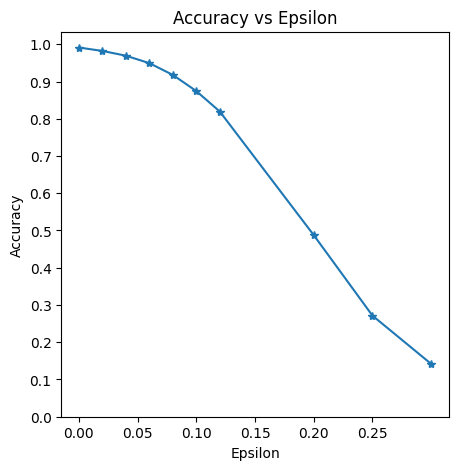

In [77]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .3, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

Epsilon: 0, Accuracy: 0.9912
Original: 7, Adversarial: 7
Original: 9, Adversarial: 9
Original: 0, Adversarial: 0
Original: 3, Adversarial: 3
Original: 5, Adversarial: 5
Epsilon: 0.02, Accuracy: 0.9821
Original: 3, Adversarial: 5
Original: 4, Adversarial: 6
Original: 3, Adversarial: 5
Original: 1, Adversarial: 3
Original: 5, Adversarial: 8
Epsilon: 0.04, Accuracy: 0.9693
Original: 3, Adversarial: 2
Original: 4, Adversarial: 9
Original: 9, Adversarial: 3
Original: 9, Adversarial: 3
Original: 8, Adversarial: 4
Epsilon: 0.06, Accuracy: 0.9493
Original: 1, Adversarial: 6
Original: 4, Adversarial: 9
Original: 4, Adversarial: 9
Original: 9, Adversarial: 8
Original: 8, Adversarial: 6
Epsilon: 0.08, Accuracy: 0.9177
Original: 7, Adversarial: 2
Original: 4, Adversarial: 8
Original: 3, Adversarial: 7
Original: 9, Adversarial: 2
Original: 7, Adversarial: 4
Epsilon: 0.1, Accuracy: 0.8743
Original: 6, Adversarial: 5
Original: 5, Adversarial: 8
Original: 8, Adversarial: 6
Original: 6, Adversarial: 2


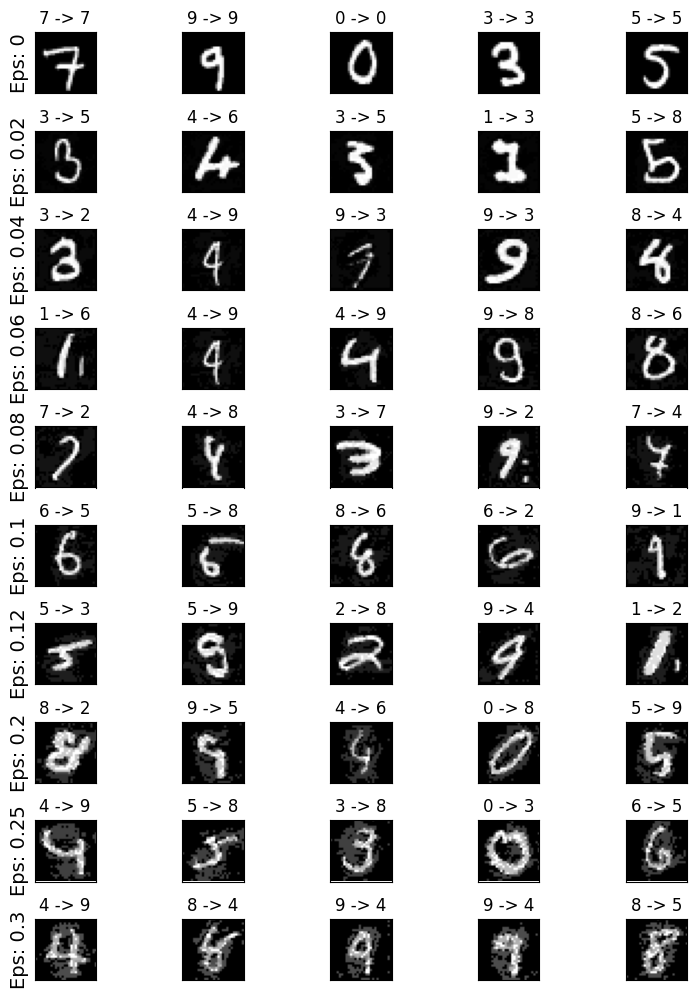

In [78]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8, 10))
for i in range(len(epsilons)):
    print(f"Epsilon: {epsilons[i]}, Accuracy: {accuracies[i]}")
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons), len(examples[0]), cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig, adv, ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
        print(f"Original: {orig}, Adversarial: {adv}")

plt.tight_layout()
plt.show()